Multi classification, position of footbalplayers based on personalized data.

In [99]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [100]:
df = pd.read_csv('data/football_players_multi.csv')
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [101]:
df.columns # Check all available features

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [102]:
# Selecting features for training a model
cols = ['Position','Age','Overall','Potential','Special','Weak Foot','Skill Moves','Jersey Number','Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking']
df = df[cols]

In [103]:
# Changing text values into a numerical values
forward_player = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder_player = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender_player = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]

df.loc[df["Position"] == "GK", "Position"] = 0
df.loc[df["Position"].isin(defender_player), "Position"] = 1
df.loc[df["Position"].isin(midfielder_player), "Position"] = 2
df.loc[df["Position"].isin(forward_player), "Position"] = 3

In [104]:
# dropping nan entries, since this will result in problem with training the model.
print(df.isna().sum())
print(len(df))
df = df.dropna(how='any')
print(len(df))


Position           60
Age                 0
Overall             0
Potential           0
Special             0
Weak Foot          48
Skill Moves        48
Jersey Number      60
Crossing           48
Finishing          48
HeadingAccuracy    48
ShortPassing       48
Volleys            48
Dribbling          48
Curve              48
FKAccuracy         48
LongPassing        48
BallControl        48
Acceleration       48
SprintSpeed        48
Agility            48
Reactions          48
Balance            48
ShotPower          48
Jumping            48
Stamina            48
Strength           48
LongShots          48
Aggression         48
Interceptions      48
Positioning        48
Vision             48
Penalties          48
Composure          48
Marking            48
dtype: int64
18207
18147


In [105]:
X = df.drop(['Position'],axis = 1) 
df['Position'] = df['Position'].astype(float)
y = df[['Position']]
print(y)
# 70% train, 20% test and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)


       Position
0           3.0
1           3.0
2           3.0
3           0.0
4           2.0
...         ...
18202       2.0
18203       3.0
18204       3.0
18205       3.0
18206       2.0

[18147 rows x 1 columns]


In [106]:
# Creat training loader and validation loader (Batches)
BATCH_SIZE=32
EPOCH = 100

X_train = torch.from_numpy(X_train.to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())
X_val = torch.from_numpy(X_val.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

train = torch.utils.data.TensorDataset(X_train,y_train)
validate = torch.utils.data.TensorDataset(X_val,y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([13065, 34]) torch.Size([13065])
torch.Size([3630, 34]) torch.Size([3630])


In [107]:
# Report the time, during training
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [108]:
# Creating neural network architecture
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 10)
    self.fc2 = nn.Linear(10, 5)
    self.fc3 = nn.Linear(5, 4)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
net = Net(X_train.shape[1])

In [109]:
# Start training model

from tqdm.notebook import tqdm
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
net = net.to(device)
print(net)
criterion = criterion.to(device)

predicted_list = []
train_acc_per_epoch = []
val_acc_per_epoch = []

for epoch in tqdm(range(EPOCH)):
    start_time = time.time()
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = (inputs).type(torch.FloatTensor), (labels).type(torch.LongTensor)
        y_pred = net(inputs)
        train_loss = criterion(y_pred, labels)
        predicted = torch.max(y_pred,1)
        total += labels.size(0)
        correct += (predicted[1] == labels).sum().item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_acc = correct / total
    train_acc_per_epoch.append(train_acc)
    correct = 0
    total = 0
    
    #VALIDATION SET
    predicted_list=[] # reset every epoch, and save the last one
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs, labels = (inputs).type(torch.FloatTensor), (labels).type(torch.LongTensor)

        # calculate outputs by running images through the network 
        y_pred = net(inputs)
        
        predicted = torch.max(y_pred,1)
        total += labels.size(0)
        correct += (predicted[1] == labels).sum().item()
        predicted_list.append(predicted[1].tolist()) 

    vall_acc = correct / total
    val_acc_per_epoch.append(vall_acc)
    correct = 0
    total = 0

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    #print(f'train_loss : {epoch_train_loss}')
    print(f'train_accuracy : {train_acc*100} val_accuracy : {vall_acc*100}')
    print(25*'==')




Net(
  (fc1): Linear(in_features=34, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=4, bias=True)
)


Epoch: 01 | Epoch Time: 0m 0s
train_accuracy : 44.30922311519326 val_accuracy : 59.06336088154271
Epoch: 02 | Epoch Time: 0m 0s
train_accuracy : 61.676234213547644 val_accuracy : 66.61157024793388
Epoch: 03 | Epoch Time: 0m 0s
train_accuracy : 66.92690394182932 val_accuracy : 68.7603305785124
Epoch: 04 | Epoch Time: 0m 0s
train_accuracy : 70.7539226942212 val_accuracy : 74.84848484848486
Epoch: 05 | Epoch Time: 0m 0s
train_accuracy : 74.91771909682357 val_accuracy : 79.77961432506888
Epoch: 06 | Epoch Time: 0m 0s
train_accuracy : 80.00765403750478 val_accuracy : 82.86501377410468
Epoch: 07 | Epoch Time: 0m 0s
train_accuracy : 81.5614236509759 val_accuracy : 83.4159779614325
Epoch: 08 | Epoch Time: 0m 0s
train_accuracy : 81.42365097588979 val_accuracy : 80.66115702479338
Epoch: 09 | Epoch Time: 0m 0s
train_accuracy : 81.86758515116725 val_accuracy : 82.69972451790633
Epoch: 10 | Epoch Time: 0m 0s
train_accuracy : 82.22732491389208 val_accuracy : 84.93112947658402
Epoch: 11 | Epoch Time:

PLOT TRAINING STATS

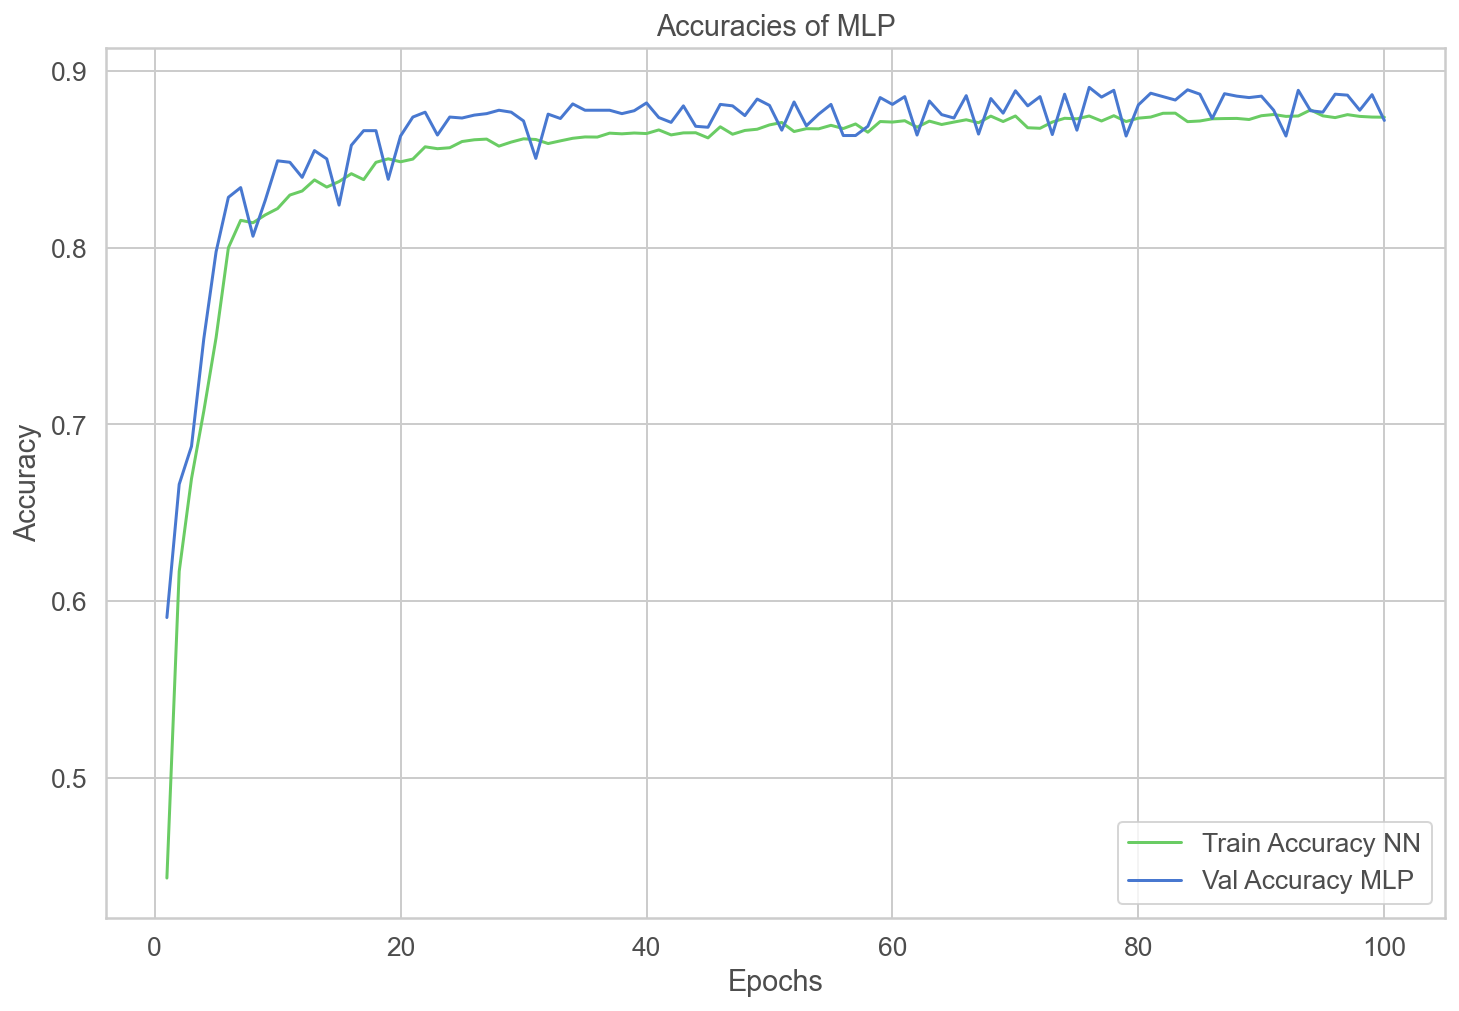

In [110]:
import matplotlib.pyplot as plt
#plt.style.use("seaborn-dark")
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '1.0'#'#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.3'  # very light grey
epochs_range = np.arange(1,EPOCH+1)
plt.plot(epochs_range, train_acc_per_epoch, 'g', label='Train Accuracy NN')
plt.plot(epochs_range, val_acc_per_epoch, 'b', label='Val Accuracy MLP')
#plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background
plt.title('Accuracies of MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

CHECK RESULTS IN CSV, A SAMPLE

In [111]:
# create dataframe formate in order to save it in a csv.
flat_predicted = [item for sublist in predicted_list for item in sublist]
predictions_df = pd.DataFrame()
predictions_df['predicted'] = flat_predicted
predictions_df['true value'] = y_test
predictions_df.to_csv('predictions_MULTICLASS_footballplayers.csv', sep='\t', encoding='utf-8')

In [112]:
torch.save(net, 'model_weights.pth') # Save model as .pth

# Make predictions on testset
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).int())

test_sample = (X_test).type(torch.FloatTensor)
prediction_model = net(test_sample)
output = torch.max(prediction_model,1)

for predictions in output:
    output_ = predictions.tolist()

y_test = y_test.tolist()
accuracy_testset = sum(1 for x,y in zip(output_,y_test) if x == y) / len(output_)

In [113]:
print('Model accuracy on testset: {:.2f}%'.format(accuracy_testset*100))

Model accuracy on testset: 88.02%
